## Torch.nn
`reference` `https://pytorch.org/tutorials/beginner/nn_tutorial.html`

### MNIST data setup

In [1]:
from pathlib import Path
import requests

In [2]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

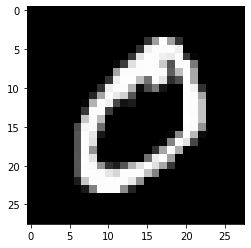

In [5]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[1].reshape((28,28)), cmap="gray")
# x_train.shape

### Neural net from scratch

In [6]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

m, n = x_train.shape # 50000, 784
print(x_train.shape)

torch.Size([50000, 784])


In [7]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [8]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(x_batch):
    return log_softmax(x_batch @ weights + bias)

In [9]:
batch_size = 64

x_batch = x_train[0:batch_size]
y_preds = model(x_batch) # predictions

In [10]:
def negative_log_likelihood(input, target):
    return -input[range(target.shape[0]), target].mean() # ?

loss_function = negative_log_likelihood 

In [11]:
y_batch = y_train[0:batch_size]
print(loss_function(y_preds, y_batch))

tensor(2.3472, grad_fn=<NegBackward>)


In [12]:
def accuracy(out, y_batch):
    y_preds = torch.argmax(out, dim=1)
    return (y_preds == y_batch).float().mean()

In [13]:
print(accuracy(y_preds, y_batch))

tensor(0.0469)


In [14]:
from IPython.core.debugger import set_trace

lr = 0.5 # learning rate
epochs = 2

for epoch in range(epochs):
    for i in range((m - 1) // batch_size + 1):
        # set_trace()
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        y_pred = model(x_batch)
        loss = loss_function(y_pred, yb)

        loss.backward()
        
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

### Using `torch.nn.functional`

In [15]:
import torch.nn.functional as F

loss_function = F.cross_entropy

def model(x_batch):
    return x_batch @ weights + bias

In [16]:
print(loss_function(model(x_batch), y_batch), accuracy(model(x_batch), y_batch))

tensor(3.0622, grad_fn=<NllLossBackward>) tensor(0.0781)


### Refactor using `nn.Module`

In [17]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, x_batch):
        return x_batch @ self.weights + self.bias

model = Mnist_Logistic()
print(loss_function(model(x_batch), y_batch))

tensor(2.4322, grad_fn=<NllLossBackward>)


In [18]:
def fit():
    for epoch in range(epochs):
        for i in range((m-1) // batch_size + 1):
            start_i = i * batch_size
            end_i = start_i + batch_size
            x_batch = x_train[start_i:end_i]
            y_batch = y_train[start_i:end_i]
            y_preds = model(x_batch)
            loss = loss_function(y_preds, y_batch)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()        

In [19]:
print(loss_function(model(x_batch), y_batch))

tensor(0.2236, grad_fn=<NllLossBackward>)


### Refactor using `nn.Linear`

In [20]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, x_batch):
        return self.lin(x_batch)
    
model = Mnist_Logistic()
print(loss_function(model(x_batch), y_batch))

tensor(2.3191, grad_fn=<NllLossBackward>)


In [21]:
fit()

print(loss_function(model(x_batch), y_batch))

tensor(0.2274, grad_fn=<NllLossBackward>)


### Refactor using `optim`

In [22]:
from torch import optim

opt = optim.SGD(model.parameters(), lr=lr)
print(loss_function(model(x_batch), y_batch))

for epoch in range(epochs):
    for i in range((m-1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        x_batch = x_train[start_i:end_i]
        y_batch = y_train[start_i:end_i]
        y_preds = model(x_batch)
        loss = loss_function(y_preds, y_batch)
            
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_function(model(x_batch), y_batch))

tensor(0.2274, grad_fn=<NllLossBackward>)
tensor(0.0652, grad_fn=<NllLossBackward>)


### Refactor using Dataset and DataLoader

In [25]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

for epoch in range(epochs):
    for x_batch, y_batch in train_dataloader:
        y_preds = model(x_batch)
        loss = loss_function(y_preds, y_batch)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_function(model(x_batch), y_batch))

tensor(0.0570, grad_fn=<NllLossBackward>)


### Add validation

In reality, you **always** should also have a `validation set`, in order to identify if you are overfitting.

Suffling the training data is **important** to prevent correlation between batches and overfitting.

We'll us a batch size for the validation set that is twice as large as that for the training set. This is because the validation set does not need backpropagation and thus takes less memory (it doesn't need to store the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.

In [26]:
train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(x_valid, y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size * 2)

In [27]:
for epoch in range(epochs):
    model.train()
    
    for x_batch, y_batch in train_dataloader:
        y_preds = model(x_batch)
        loss = loss_function(y_preds, y_batch)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_function(model(x_batch), y_batch) for x_batch, y_batch in valid_dataloader)
    
    print(epoch, valid_loss / len(valid_dataloader))
        

0 tensor(0.2596)
1 tensor(0.3202)


In [28]:
def loss_batch(model, loss_function, x_batch, y_batch, opt=None):
    loss = loss_function(model(x_batch), y_batch)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(x_batch)

def fit(epochs, model, loss_function, opt, train_dataloader, valid_dataloader):
    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_dataloader:
            loss_batch(model, loss_function, x_batch, y_batch, opt)
        
        model.eval()
        
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_function, x_batch, y_batch) for x_batch, y_batch in valid_dataloader]
            )
            
        valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print(epoch, valid_loss)

In [29]:
fit(epochs, model, loss_function, opt, train_dataloader, valid_dataloader)

0 0.31481205644607546
1 0.502657348203659


In [33]:
class Mnist_CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x_batch):
        # C H W
        x_batch = x_batch.view(-1, 1, 28, 28)
        x_batch = F.relu(self.conv1(x_batch))
        x_batch = F.relu(self.conv2(x_batch))
        x_batch = F.relu(self.conv3(x_batch))
        x_batch = F.avg_pool2d(x_batch, 4)
        return x_batch.view(-1, x_batch.size(1))

In [34]:
lr = .1
model=Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=.9)

fit(epochs, model, loss_function, opt, train_dataloader, valid_dataloader)

0 0.34022742376327514
1 0.2648936599731445


### nn.Sequential

A `Sequential` object runs each of the modules contained within it, in a sequential manner.

In [35]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [37]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1))
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=.9)

fit(epochs, model, loss_function, opt, train_dataloader, valid_dataloader)

0 0.3397465608596802
1 0.2597434866905212


### Wrapping DataLoader

In [39]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    
    def __init__(self, dataloader, func):
        self.dataloader = dataloader
        self.func = func
    
    def __len__(self):
        return len(self.dataloader)
    
    def __iter__(self):
        batches = iter(self.dataloader)
        for batch in batches:
            yield(self.func(*batch))
            
train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
valid_dataloader = WrappedDataLoader(valid_dataloader, preprocess)

In [40]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1))
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=.9)

fit(epochs, model, loss_function, opt, train_dataloader, valid_dataloader)

0 0.36821770782470703
1 0.24447044944763183


### Using GPU

In [ ]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(dev)

opt = optim.SGD(model.parameters(), lr=lr, momentum=.9)

fit(epochs, model, loss_function, opt, train_dataloader, valid_dataloader)